In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed

# Store the images into a dataframe

Caption to Gemini:

> i have a folder structure with jpg images of size 64x64, can you provide some python code to walk through the folder structure, pick each image load it into a numpy array, transform the RGB matrix of size 64x64x3 into a single array of length of length 64x64 collapsing the colors and stack everything together into a pandas dataframe with a column obj_id corresponding to the name of the jpg image and 64x64 columns corresponding to the pixels. I would like to do this in an efficient way with many threads in parallel

Changed the base_name and obj_id to remove the .jpg extension

In [2]:
def process_image(img_path):
    """
    Loads an image, converts it to a NumPy array, collapses
    the color channels, and returns the image name and the flattened pixel array.
    """
    try:
        # Load the image
        img = Image.open(img_path).convert('RGB')
        # Convert to a NumPy array
        img_array = np.array(img)
        # Collapse the RGB channels by taking the mean
        # A simple method to reduce the 3-channel matrix
        collapsed_array = np.mean(img_array, axis=2)
        # Flatten the array to a single dimension
        flattened_array = collapsed_array.flatten()

        # Get the object ID from the filename
        base_name = os.path.basename(img_path)
        obj_id = os.path.splitext(base_name)[0]

        return obj_id, flattened_array
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None

def create_dataframe_parallel(folder_path):
    """
    Walks through a folder, processes all JPG images in parallel,
    and returns a Pandas DataFrame.
    """
    image_paths = []
    # Recursively find all .jpg files in the folder
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    all_data = []
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        # Submit tasks for each image file
        future_to_path = {executor.submit(process_image, path): path for path in image_paths}
        
        # Collect results as they are completed
        for future in as_completed(future_to_path):
            obj_id, pixel_array = future.result()
            if obj_id and pixel_array is not None:
                # Create a dictionary for the row, ensuring the obj_id is first
                row_dict = {'obj_id': obj_id}
                # Add the pixel data to the dictionary
                row_dict.update({f'pixel_{i}': val for i, val in enumerate(pixel_array)})
                all_data.append(row_dict)

    # Create the DataFrame
    if not all_data:
        print("No images were processed. The DataFrame is empty.")
        return pd.DataFrame()
    
    df = pd.DataFrame(all_data)
    # Set 'obj_id' as the first column
    cols = ['obj_id'] + [col for col in df.columns if col != 'obj_id']
    df = df[cols]
    
    return df

In [3]:
folder = '/data/pic/scratch/torradeflot/PythonBootcamp/HIPS2FITS_petro'
df = create_dataframe_parallel(folder)

In [4]:
df

,obj_id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_4086,pixel_4087,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095
0,1237665549436911906,11.000000,12.000000,12.000000,9.000000,5.000000,5.000000,8.000000,13.000000,10.000000,...,9.333333,6.333333,12.333333,5.333333,2.000000,4.333333,6.333333,4.333333,2.666667,3.333333
1,1237668289622442106,3.000000,2.000000,3.000000,5.000000,7.333333,8.333333,6.333333,4.000000,8.000000,...,6.333333,6.333333,7.000000,5.333333,3.333333,4.000000,7.333333,10.666667,13.000000,14.000000
2,1237657222560743706,7.000000,5.000000,1.666667,0.333333,0.333333,2.333333,7.000000,9.000000,6.000000,...,10.666667,9.666667,11.666667,7.666667,4.666667,7.666667,13.666667,14.666667,8.666667,2.666667
3,1237658302743118006,1.666667,4.000000,8.000000,8.000000,6.000000,5.000000,7.000000,9.000000,5.000000,...,3.000000,2.333333,7.000000,8.000000,8.000000,9.000000,9.000000,8.000000,8.000000,7.000000
4,1237652599567483306,5.666667,4.666667,3.000000,5.000000,8.000000,11.000000,11.000000,11.000000,8.000000,...,5.666667,4.666667,6.666667,3.666667,4.666667,11.666667,14.666667,11.666667,8.666667,7.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69160,1237659326562042147,13.666667,9.666667,8.666667,10.000000,9.000000,5.666667,6.666667,9.333333,4.333333,...,2.000000,4.666667,3.666667,2.666667,2.000000,3.666667,7.666667,9.666667,8.666667,6.666667
69161,1237662336791150747,8.666667,5.666667,2.666667,3.666667,6.666667,8.666667,6.666667,3.666667,5.666667,...,3.666667,1.666667,4.666667,3.666667,2.666667,2.666667,3.666667,4.666667,6.666667,7.666667
69162,1237657609113960547,3.000000,4.000000,5.000000,6.000000,6.000000,6.000000,6.000000,5.000000,5.000000,...,4.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,7.000000,7.000000,7.000000
69163,1237662300824338547,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,4.000000,...,4.666667,3.666667,1.666667,3.000000,5.666667,7.666667,7.666667,7.666667,9.666667,11.666667


In [8]:
69165*4096*8/1024/1024/1024

2.110748291015625

In [9]:
df.to_parquet('/data/pic/scratch/torradeflot/PythonBootcamp/ZooStamps.parquet')

In [9]:
df = pd.read_parquet('/data/pic/scratch/torradeflot/PythonBootcamp/ZooStamps.parquet')

# Checking the content of the df

Gemini caption: 

> Now, given a row of the dataframe, I would like to plot the image to check it is correct

It didn't work out of the box, I had to add the `.astype('float')`

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_from_dataframe(dataframe, row_index):
    """
    Plots an image from a specified row of the DataFrame.

    Args:
        dataframe (pd.DataFrame): The DataFrame containing the image data.
        row_index (int): The index of the row to plot.
    """
    # Select the specific row
    row = dataframe.iloc[row_index]
    
    # Extract the image ID (obj_id)
    obj_id = row['obj_id']
    print(f"Plotting image for object ID: {obj_id}")

    # Extract only the pixel columns
    pixel_data = row.drop('obj_id')
    
    # Convert the pandas Series of pixel values to a NumPy array
    # and reshape it back to the original 64x64 dimensions.
    # The 'values' attribute is used for efficiency.
    image_array = pixel_data.values.reshape(64, 64).astype('float')

    # Plot the image using Matplotlib.
    # We use a grayscale colormap as the RGB channels were collapsed.
    plt.imshow(image_array, cmap='gray')
    plt.title(f'Image from DataFrame: {obj_id}')
    plt.show()

Plotting image for object ID: 1237660583368065200


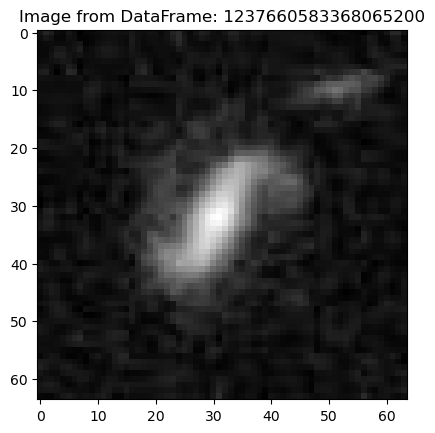

In [24]:
plot_image_from_dataframe(df, 200)

# Apply PCA

> provide me the python code to apply a PCA to the df using scikit learn to keep only the 64 most significant elements
> I want to save the PCA model, can you separate the fit and transform parts, so that I can save the model?

In [12]:
import joblib
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming 'df' is the DataFrame you created in the previous steps

# Separate the image IDs and the pixel data
pixel_data = df.drop(columns=['obj_id'])

scaler = StandardScaler()
pixel_scaled = scaler.fit_transform(pixel_data)

# Initialize PCA with 64 components
n_components = 0.95
pca = PCA(n_components=n_components)

# Fit the PCA model to the pixel data
# Note: We use .fit() here, not .fit_transform()
pca.fit(pixel_scaled)

# Save the fitted PCA model to a file
model_filename = '/data/pic/scratch/torradeflot/PythonBootcamp/PCA.joblib'
joblib.dump(pca, model_filename)

print(f"PCA model has been saved to '{model_filename}'")

PCA model has been saved to '/data/pic/scratch/torradeflot/PythonBootcamp/PCA.joblib'


# Check PCA

> please provide the python code to get the amount of information preserved as a function of the number of components and a method to plot the components as 64x64 images
> I want you to provide the python code to do these plots

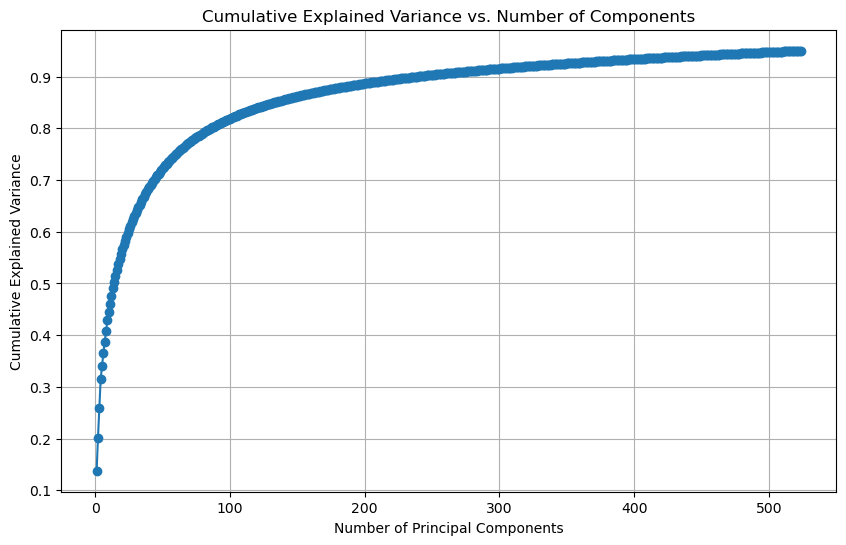

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca_components(pca_model, num_components, img_dim=(64, 64)):
    """
    Plots the principal components as images.
    
    Args:
        pca_model (sklearn.decomposition.PCA): The fitted PCA model.
        num_components (int): The number of components to plot.
        img_dim (tuple): The dimensions of the original image (e.g., (64, 64)).
    """
    # Create a grid for the plots
    n_rows = int(np.ceil(np.sqrt(num_components)))
    n_cols = int(np.ceil(num_components / n_rows))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()

    for i in range(num_components):
        if i < len(pca_model.components_):
            component = pca_model.components_[i].reshape(img_dim)
            ax = axes[i]
            ax.imshow(component, cmap='gray')
            ax.set_title(f'PC {i+1}')
            ax.axis('off')
        else:
            axes[i].axis('off') # Hide unused subplots
    
    plt.tight_layout()
    plt.suptitle(f'First {num_components} Principal Components as Images', y=1.02)
    plt.show()



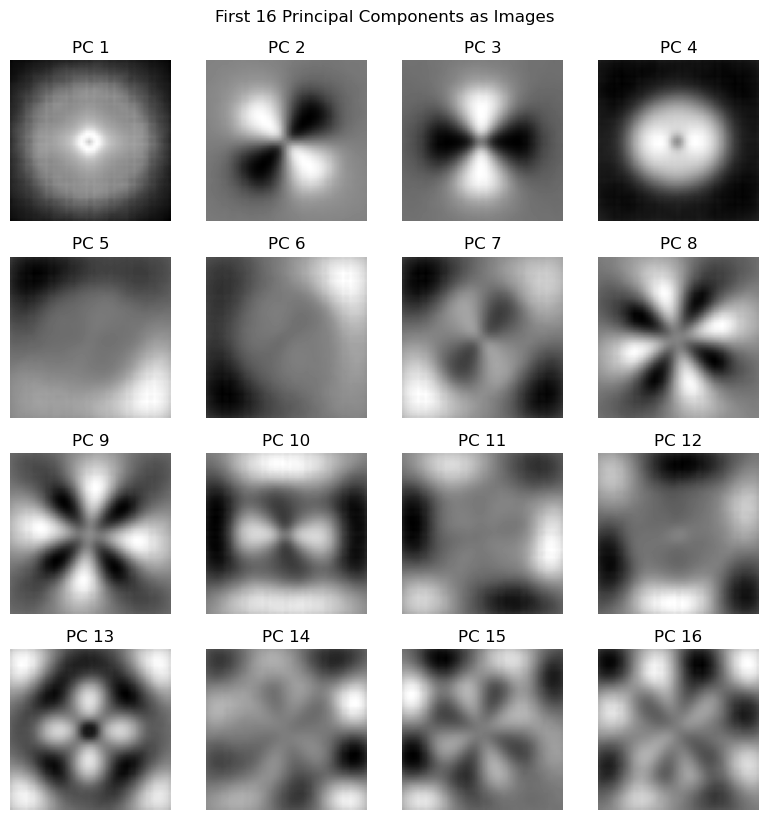

In [15]:
plot_pca_components(pca, num_components=16)

# Save transformed dataset

In [19]:
import pandas as pd
from sklearn.decomposition import PCA

# --- Start of the PCA application code ---

# Separate the image IDs and the pixel data
obj_ids = df['obj_id']
pixel_data = df.drop(columns=['obj_id'])

# Transform the data
pca_transformed_data = pca.transform(pixel_scaled)

# Create a new DataFrame with the PCA-transformed data
pca_df = pd.DataFrame(data=pca_transformed_data,
                      columns=[f'PC_{i+1}' for i in range(pca_transformed_data.shape[1])])

# Add the obj_id column back to the new DataFrame
pca_df.insert(0, 'obj_id', obj_ids)

# Display the first 5 rows and the shape of the new DataFrame
print("\nDataFrame after PCA:")
print(pca_df.head())
print("\nShape of the new DataFrame:", pca_df.shape)


DataFrame after PCA:
                obj_id       PC_1       PC_2       PC_3       PC_4       PC_5  \
0  1237665549436911906  37.329479  26.374165 -16.487439 -25.624104  22.588669   
1  1237668289622442106  19.536629 -10.450369  32.417307   6.044394   2.346708   
2  1237657222560743706  -3.587915  14.689209 -31.561519  -2.499770   4.609235   
3  1237658302743118006 -19.003201   7.431230  -6.596095 -13.908933   4.191637   
4  1237652599567483306  -5.668331 -21.541816  17.805574  -9.870930  -3.578131   

        PC_6       PC_7       PC_8       PC_9  ...    PC_515    PC_516  \
0  17.619670 -23.815926  -8.991450  21.851680  ... -1.852469 -0.220437   
1  -3.517122   4.946158  -2.079284  10.054229  ... -0.729347 -1.414598   
2  -4.042427   2.852856  -8.616241  19.370440  ... -0.509141 -0.493146   
3  -7.545103   3.398297  -2.957237  -1.312233  ...  0.718656 -0.105270   
4   2.783184  -0.121471 -13.283662   7.899675  ...  1.641131  0.499081   

     PC_517    PC_518    PC_519    PC_520    P

In [20]:
pca_transformed_data.shape

(69165, 524)

In [21]:
pca_df.to_parquet('/data/pic/scratch/torradeflot/PythonBootcamp/ZooStampsPCA.parquet')

# Build merged df

In [22]:
pca_df = pd.read_parquet('/data/pic/scratch/torradeflot/PythonBootcamp/ZooStampsPCA.parquet')

In [23]:
catalog_df = pd.read_csv('/data/pic/scratch/torradeflot/PythonBootcamp/ZooSpecPhotoDR19_filtered.csv')

In [24]:
catalog_df['obj_id'] = catalog_df.objid.astype('str')

In [25]:

catalog_df.head()

,Unnamed: 0,specobjid,objid,dr7objid,ra,dec,p_el_debiased,p_cs_debiased,spiral,elliptical,...,modelMag_g,modelMag_r,modelMag_i,modelMag_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,obj_id
0,1,1578598304118237184,1237661463301456237,587735742076551517,233.7615,34.60428,0.000,1.000,1,0,...,18.52618,17.26985,16.74385,16.40496,0.113007,0.083150,0.060307,0.045729,0.032422,1237661463301456237
1,3,1578599678507771904,1237661463301521650,587735742076616950,233.9483,34.48045,0.069,0.931,1,0,...,18.59320,17.56006,16.99352,16.56135,0.119059,0.087602,0.063536,0.048178,0.034159,1237661463301521650
2,7,1578583460711262208,1237661463301718141,587735742076813455,234.3422,34.38433,0.015,0.985,1,0,...,18.06115,17.53488,17.15096,16.99754,0.128975,0.094899,0.068828,0.052191,0.037004,1237661463301718141
3,20,1578572190717077504,1237661463302045898,587735742077141189,235.0977,33.95142,0.040,0.939,1,0,...,18.17520,17.32843,16.83691,16.51041,0.154629,0.113775,0.082519,0.062572,0.044364,1237661463302045898
4,29,1579718437544945664,1237661463302308093,587735742077403410,235.8138,33.56461,0.000,1.000,1,0,...,17.89112,17.29951,16.94029,16.72308,0.191923,0.141215,0.102421,0.077663,0.055064,1237661463302308093


In [26]:
df_all = pd.merge(left=catalog_df, right=pca_df, on='obj_id', how='inner')

In [27]:
df_all.head()

,Unnamed: 0,specobjid,objid,dr7objid,ra,dec,p_el_debiased,p_cs_debiased,spiral,elliptical,...,PC_515,PC_516,PC_517,PC_518,PC_519,PC_520,PC_521,PC_522,PC_523,PC_524
0,1,1578598304118237184,1237661463301456237,587735742076551517,233.7615,34.60428,0.000,1.000,1,0,...,0.536912,0.064503,0.259676,-0.289021,-0.862953,0.420371,0.329216,0.314249,-0.050586,0.700211
1,3,1578599678507771904,1237661463301521650,587735742076616950,233.9483,34.48045,0.069,0.931,1,0,...,0.001219,-0.558252,0.261005,-0.110078,0.340894,-0.277731,0.400253,-0.055266,0.976397,0.267087
2,7,1578583460711262208,1237661463301718141,587735742076813455,234.3422,34.38433,0.015,0.985,1,0,...,0.675641,-0.651424,0.150639,0.473218,0.230787,-1.125981,-0.370061,-0.895124,0.490179,0.153672
3,20,1578572190717077504,1237661463302045898,587735742077141189,235.0977,33.95142,0.040,0.939,1,0,...,1.347645,0.245158,0.836806,-0.440211,0.446097,0.434959,0.420837,-0.276940,-0.192768,0.318484
4,29,1579718437544945664,1237661463302308093,587735742077403410,235.8138,33.56461,0.000,1.000,1,0,...,-0.224103,-0.019193,-0.211736,-0.187336,-0.653817,0.857071,0.334725,-0.251544,-0.159240,0.945631


# Train classifier

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

In [29]:
# Separate features (X) and target (y)
features = df_all.drop(columns=['Unnamed: 0', 'specobjid', 'objid', 'dr7objid', 'ra', 'dec',
                                  'p_el_debiased', 'p_cs_debiased', 'spiral', 'elliptical',
                               'obj_id'])
target = df_all['spiral']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Initialize and train the Support Vector Machine (SVC) classifier
svm_classifier = LinearSVC(random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy on the test set: {accuracy:.2f}")

Model accuracy on the test set: 0.96
